В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [41]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [42]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [43]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [44]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000, eps = 10**-2):
        self.layer_sizes = hidden_layer_sizes 
        self.layers_count = len(self.layer_sizes) + 1
        self.normalize = normalize 
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.eps = eps
        
        self.COST_APPEND_T = 1
        
    def __normalize(self, X, mean = None, std = None):
        m = mean
        if m is None:
            m = np.array([np.mean(X, axis=1)]).T
        s = std
        if s is None:
            s = np.array([np.std(X, axis=1)]).T
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self):
        self.parameters = {}
        n_i = self.layer_sizes
        for i in range(1, self.layers_count + 1):
            self.parameters[f"W{i}"] = np.random.randn(n_i[i], n_i[i - 1]) * np.sqrt(2/n_i[i - 1])
            self.parameters[f"b{i}"] = np.zeros((n_i[i], 1))
       
    def __forward_propagation(self, X):
        cache = {"A0" : X}
        for i in range(1, self.layers_count + 1):
            cache[f"Z{i}"] = np.dot(self.parameters[f"W{i}"], cache[f"A{i - 1}"]) + self.parameters[f"b{i}"]
            cache[f"A{i}"] = self.__sigmoid(cache[f"Z{i}"])

        return cache[f"A{self.layers_count}"], cache
        

    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        gradients = {}
        for i in reversed(range(1, self.layers_count + 1)):
            if i == self.layers_count:
                gradients[f"dZ{i}"] = cache[f"A{i}"] - Y
            else:
                dAi = np.dot(self.parameters[f"W{i + 1}"].T, gradients[f"dZ{i + 1}"])
                gradients[f"dZ{i}"] = np.multiply(dAi, cache[f"A{i}"] * (1 - cache[f"A{i}"]))
                
            gradients[f"dW{i}"] = (1/m) * np.dot (gradients[f"dZ{i}"], cache[f"A{i - 1}"].T)  
            gradients[f"db{i}"] = (1/m) * np.sum(gradients[f"dZ{i}"], axis = 1, keepdims = True)
                
        return gradients
    
    def __update_parameters(self, gradients):
        for i in range(1, self.layers_count + 1):
            dWi = gradients[f"dW{i}"]
            dbi = gradients[f"db{i}"]
            self.parameters[f"W{i}"] -= self.learning_rate * dWi
            self.parameters[f"b{i}"] -= self.learning_rate * dbi

    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T #Convert vertical to horizontal matrices
        
        if self.normalize: #Normalize
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = [] #Costs log

        if(len(self.layer_sizes) - 1 != self.layers_count):
            self.layer_sizes.insert(0, X.shape[0]) #Input layer
            self.layer_sizes.append(1) #Output layer
        
        self.__initialize_parameters()
        print(self.parameters)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            gradients = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(gradients)

            #OUTPUT
            if print_cost and i % 1000 == 0: #Print cost every 1000 iterations
                print("{}-th iteration: {}".format(i, cost))

            if i % self.COST_APPEND_T == 0: #Append cost every 1000 iterations
                costs.append(cost)
            
            if(i>=self.COST_APPEND_T*2):
                if(abs(costs[-1] - costs[-2]) < self.eps):
                    break

        #Plot costs
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel(f"Iteration, *{self.COST_APPEND_T}")
            plt.show()
        

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)    
        
        probabilities = self.__forward_propagation(X)[0]
        return probabilities.T
        
    def predict(self, X_vert):
        positive_probabilities = self.predict_proba(X_vert)[:, 0]
        return (positive_probabilities >= 0.5).astype(int)   


Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [45]:
# data_columns = ["exam1", "exam2"]
# target_column = "submitted"
# df = pd.read_csv("sats.csv")
# X, Y = df[data_columns].values, df[target_column]#.reshape((df.shape[0], 1))
# print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [46]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = np.array(df[data_columns].values), np.array(df[target_column].values)
print('Training set: X={}, y={}'.format(X.shape, Y.shape))


Training set: X=(118, 2), y=(118,)


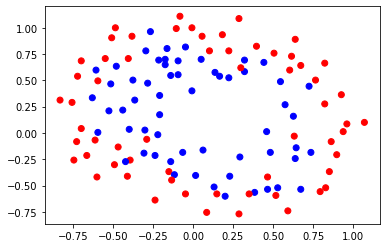

In [47]:
plot_data(X, Y)

In [48]:
cls = NeuralNet(hidden_layer_sizes=[4, 3, 2], normalize = True, learning_rate = 0.05, num_iter = 100000, eps=10**-15)

{'W1': array([[ 1.12918826,  0.63102115],
       [ 0.99580255, -0.35249215],
       [-1.22102015,  2.05211993],
       [ 0.14668172,  0.09034961]]), 'b1': array([[0.],
       [0.],
       [0.],
       [0.]]), 'W2': array([[ 0.39980412, -0.61335302,  0.56055763, -0.67094301],
       [-1.2500953 ,  0.48977717, -0.47702909, -0.01489752],
       [ 1.42967725,  0.85067583, -1.0910771 , -0.02798565]]), 'b2': array([[0.],
       [0.],
       [0.]]), 'W3': array([[-0.66838973, -0.67403981,  0.73698996],
       [-1.97115459,  0.77164127, -0.54825181]]), 'b3': array([[0.],
       [0.]]), 'W4': array([[-0.02286407,  0.93990031]]), 'b4': array([[0.]])}
0-th iteration: 0.7031475602028476
1000-th iteration: 0.6928619259043296
2000-th iteration: 0.6925026587062525
3000-th iteration: 0.6920877986264693
4000-th iteration: 0.6915751440058544
5000-th iteration: 0.6909096818662387
6000-th iteration: 0.6900157067819808
7000-th iteration: 0.688787090817304
8000-th iteration: 0.6870745600773183
9000-th itera

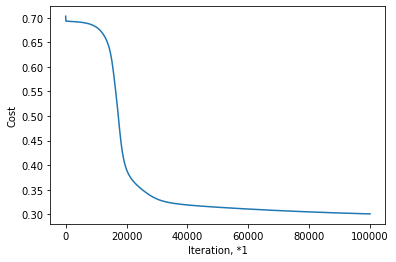

In [49]:
cls.fit(X, Y.reshape((df.shape[0], 1)))

In [50]:
cls.parameters

{'W1': array([[ 2.72332607,  1.96291955],
        [ 3.79439424, -1.45875069],
        [ 0.09442572,  2.09136755],
        [ 6.15156538, -1.94280546]]),
 'b1': array([[-2.60975008],
        [ 4.66520921],
        [ 2.18173292],
        [-0.93246248]]),
 'W2': array([[ 4.96870886, -2.86465545, -2.02711817, -3.08028798],
        [-2.75106023,  3.31196766,  4.72451012, -0.01802592],
        [ 4.6694725 , -0.48752681, -5.29150201, -2.25067216]]),
 'b2': array([[ 2.46536149],
        [-4.4998508 ],
        [ 3.24983605]]),
 'W3': array([[ 2.40191297, -4.62825933,  4.22510452],
        [-6.61624115,  6.99796904, -7.43860364]]),
 'b3': array([[0.01045188],
        [0.65816534]]),
 'W4': array([[-8.21621904,  8.19617883]]),
 'b4': array([[-5.19793534]])}

In [51]:
print(cls.parameters)

{'W1': array([[ 2.72332607,  1.96291955],
       [ 3.79439424, -1.45875069],
       [ 0.09442572,  2.09136755],
       [ 6.15156538, -1.94280546]]), 'b1': array([[-2.60975008],
       [ 4.66520921],
       [ 2.18173292],
       [-0.93246248]]), 'W2': array([[ 4.96870886, -2.86465545, -2.02711817, -3.08028798],
       [-2.75106023,  3.31196766,  4.72451012, -0.01802592],
       [ 4.6694725 , -0.48752681, -5.29150201, -2.25067216]]), 'b2': array([[ 2.46536149],
       [-4.4998508 ],
       [ 3.24983605]]), 'W3': array([[ 2.40191297, -4.62825933,  4.22510452],
       [-6.61624115,  6.99796904, -7.43860364]]), 'b3': array([[0.01045188],
       [0.65816534]]), 'W4': array([[-8.21621904,  8.19617883]]), 'b4': array([[-5.19793534]])}


In [52]:
X

array([[ 0.46601  , -0.53582  ],
       [ 0.322    ,  0.5826   ],
       [-0.75518  ,  0.2902   ],
       [-0.10426  ,  0.99196  ],
       [-0.40956  , -0.41155  ],
       [-0.28859  , -0.060673 ],
       [-0.66302  , -0.21418  ],
       [ 0.79435  , -0.55775  ],
       [ 0.63265  , -0.030612 ],
       [-0.30012  ,  0.027047 ],
       [ 0.062788 , -0.16301  ],
       [-0.39228  , -0.25804  ],
       [ 0.44297  ,  0.67032  ],
       [ 0.057028 ,  0.91886  ],
       [-0.13882  , -0.27266  ],
       [ 0.59274  , -0.7405   ],
       [-0.62846  ,  0.33406  ],
       [ 0.63882  , -0.24342  ],
       [ 0.016705 , -0.40424  ],
       [ 0.28744  , -0.76974  ],
       [-0.092742 ,  0.55336  ],
       [-0.39804  ,  0.034357 ],
       [-0.52477  ,  0.2098   ],
       [-0.0063364,  0.99927  ],
       [-0.60541  ,  0.59722  ],
       [-0.16187  ,  0.8019   ],
       [-0.61118  , -0.067982 ],
       [-0.38076  ,  0.91886  ],
       [ 0.14919  , -0.57968  ],
       [ 0.22984  , -0.41155  ],
       [ 0

In [53]:
Y_probabilities = cls.predict_proba(X)
Y_probabilities

array([[7.37891568e-01],
       [9.06114114e-01],
       [1.45895084e-02],
       [4.06805569e-02],
       [4.14060386e-04],
       [9.18947290e-01],
       [3.22192453e-04],
       [2.03198424e-02],
       [9.24767114e-01],
       [9.29519187e-01],
       [9.39684101e-01],
       [4.55881311e-01],
       [6.79038702e-01],
       [1.28871009e-03],
       [8.35258923e-01],
       [6.38952739e-03],
       [4.79118860e-01],
       [9.14666983e-01],
       [8.75713349e-01],
       [6.17638718e-03],
       [9.36032325e-01],
       [9.22113242e-01],
       [8.87368098e-01],
       [4.78003588e-04],
       [2.68848025e-01],
       [9.05106386e-01],
       [3.20104305e-01],
       [4.27485198e-01],
       [5.70778385e-01],
       [9.10695743e-01],
       [9.15565479e-01],
       [6.67580799e-01],
       [6.56593408e-01],
       [9.24443011e-01],
       [1.09205439e-02],
       [8.64074567e-01],
       [6.40317636e-01],
       [1.28978800e-02],
       [9.39325733e-01],
       [7.39026533e-02],


In [54]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [55]:
np.array(Y)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0], dtype=int64)

In [56]:
accuracy_score(Y, Y_hat)

0.8559322033898306

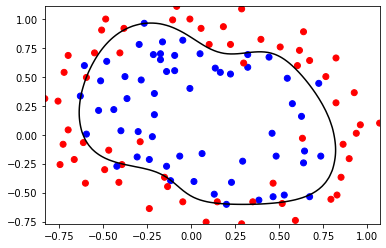

In [57]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [88]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20, ), max_iter = 100000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [89]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=100000)

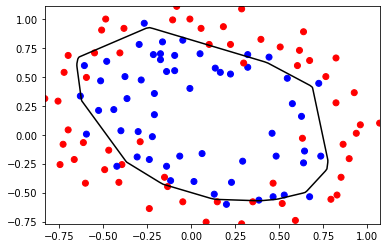

In [90]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [91]:
accuracy_score(Y, clf.predict(X))

0.8559322033898306

In [92]:
clf.n_iter_

1247